In [1]:
#unzipping here in colab session
#!unzip '/content/drive/My Drive/MonuSeg-20200317T123814Z-001.zip'

Archive:  /content/drive/My Drive/MonuSeg-20200317T123814Z-001.zip
  inflating: MonuSeg/Test/TissueImages/TCGA-A6-6782-01A-01-BS1.tif  
  inflating: MonuSeg/Test/TissueImages/TCGA-44-2665-01B-06-BS6.tif  
  inflating: MonuSeg/Test/TissueImages/TCGA-AO-A0J2-01A-01-BSA.tif  
  inflating: MonuSeg/Test/TissueImages/TCGA-GL-6846-01A-01-BS1.tif  
  inflating: MonuSeg/Test/TissueImages/TCGA-IZ-8196-01A-01-BS1.tif  
  inflating: MonuSeg/Test/TissueImages/TCGA-EJ-A46H-01A-03-TSC.tif  
  inflating: MonuSeg/Test/TissueImages/TCGA-69-7764-01A-01-TS1.tif  
  inflating: MonuSeg/Test/TissueImages/TCGA-ZF-A9R5-01A-01-TS1.tif  
  inflating: MonuSeg/Test/TissueImages/TCGA-HT-8564-01Z-00-DX1.tif  
  inflating: MonuSeg/Test/TissueImages/TCGA-AC-A2FO-01A-01-TS1.tif  
  inflating: MonuSeg/Test/TissueImages/TCGA-HC-7209-01A-01-TS1.tif  
  inflating: MonuSeg/Training/GroundTruth/TCGA-CH-5767-01Z-00-DX1_bin_mask.png  
  inflating: MonuSeg/Training/GroundTruth/TCGA-50-5931-01Z-00-DX1_bin_mask.png  
  inflating:

In [3]:
#%reset
import tensorflow as tf
print(tf.__version__)

1.15.0


In [4]:
#Dataset MonuSeg
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

#import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
#from keras.layers.core import Lambda, RepeatVector, Reshape
#from keras.layers.convolutional import Conv2D, Conv2DTranspose
#from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
#from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.optimizers import SGD

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [0]:
# Set some parameters
im_width = 512
im_height = 512
depth = 1
#border = 5

In [6]:
# list of names all images in the given path
ids_train = next(os.walk("./MonuSeg/Training/TissueImages"))[2]
print("No. of images in training set= ", len(ids_train))

# list of names all images in the given path
ids_test = next(os.walk("./MonuSeg/Test/TissueImages"))[2]
print("No. of images in testing set = ", len(ids_test))

No. of images in training set=  30
No. of images in testing set =  14


In [0]:
#train
X_train = np.zeros((len(ids_train), im_height, im_width, depth ), dtype=np.float32)
y_train = np.zeros((len(ids_train), im_height, im_width, depth), dtype=np.float32)

#test
X_test = np.zeros((len(ids_test), im_height, im_width, depth), dtype=np.float32)
y_test = np.zeros((len(ids_test), im_height, im_width, depth), dtype=np.float32)

In [8]:
X_train.shape

(30, 512, 512, 1)

In [9]:
#train

# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids_train), total=len(ids_train)):
    # Load images
    img = load_img("MonuSeg/Training/TissueImages/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, depth), mode = 'constant', preserve_range = True)
    
    #rename mask
    d = id_.split('.')
    d[0] = d[0]+"_bin_mask."
    id_ = d[0]+d[1]
    #print(id_)
    #renamed becuase GT in filenames include _bin_mask in names
    
    # Load masks
    mask = img_to_array(load_img("MonuSeg/Training/GroundTruth/"+id_, grayscale=True))
    mask = resize(mask, (im_width, im_height, depth), mode = 'constant', preserve_range = True)
    # Save images
    X_train[n] = x_img/255.0
    y_train[n] = mask/255.0
    
    
    
#test

# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids_test), total=len(ids_test)):
    # Load images
    img = load_img("MonuSeg/Test/TissueImages/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, depth), mode = 'constant', preserve_range = True)
    
    #rename mask
    d = id_.split('.')
    d[0] = d[0]+"_bin_mask."
    id_ = d[0]+"png"
    #print(id_)
    #renamed becuase GT in filenames include _bin_mask in names
    
    # Load masks
    mask = img_to_array(load_img("MonuSeg/Test/GroundTruth/"+id_, grayscale=True))
    mask = resize(mask, (im_width, im_height, depth), mode = 'constant', preserve_range = True)
    # Save images
    X_test[n] = x_img/255.0
    y_test[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


6
True


Text(0.5, 1.0, 'Mask')

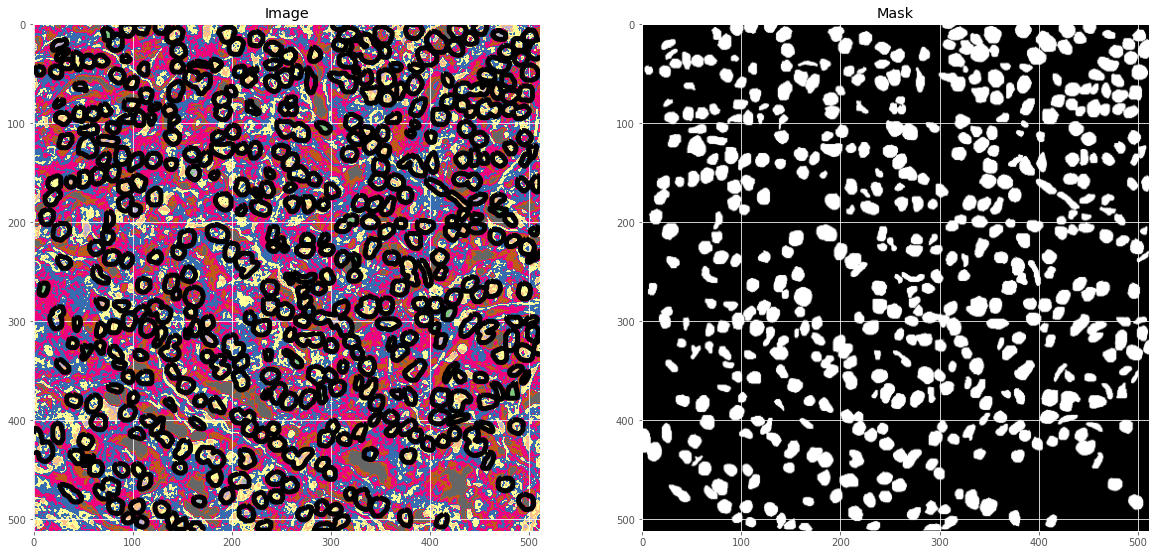

In [10]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
print(ix)
has_mask = y_train[ix].max() > 0 # salt indicator
print(has_mask)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'Accent', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Image')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask')


In [0]:
#metrics
import keras.backend as K
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [0]:
import os
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, Sequential, load_model
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical  
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Flatten, PReLU,Input,LeakyReLU
from keras.layers import UpSampling2D,BatchNormalization,Reshape,Permute,Activation  
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers import concatenate,Add,Subtract,Average,UpSampling2D
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


def conv2d_layers(x,n_kernal,pool=False):
    x = Conv2D(n_kernal, (3,3), strides=(1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    if pool:
        x = MaxPooling2D(pool_size=(2,2))(x)
    return x

def conv2d_decode(x1,x2,n_kernal):
    x = concatenate([x1,x2],axis=3)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(n_kernal, (3,3), strides=(1, 1), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    return x

def build_model(input_img):
    # encoder
    # 256
    block1 = conv2d_layers(input_img,32)
    block1 = conv2d_layers(block1,32,True)
    # 128
    block2 = conv2d_layers(block1,64)
    block2 = conv2d_layers(block2,64,True)
    # 64
    block3 = conv2d_layers(block2,128)
    block3 = conv2d_layers(block3,128)
    block3 = conv2d_layers(block3,128,True)
    # 32
    block4 = conv2d_layers(block3,256)
    block4 = conv2d_layers(block4,256)
    block4 = conv2d_layers(block4,256,True)
    # 16
    block5 = conv2d_layers(block4,256)
    block5 = conv2d_layers(block5,256)
    block5 = conv2d_layers(block5,256,True)
    # 8
    # decoder
    block6 = UpSampling2D(size=(2, 2))(block5)
    block6 = conv2d_layers(block6,256)
    block6 = conv2d_layers(block6,256)
    block6 = conv2d_layers(block6,256)
    # 16
    block7 = conv2d_decode(block6,block4,256)
    block7 = conv2d_layers(block7,256)
    block7 = conv2d_layers(block7,256)
    # 32
    block8 = conv2d_decode(block7,block3,128)
    block8 = conv2d_layers(block8,128)
    # 64
    block9 = conv2d_decode(block8,block2,64)
    block9 = conv2d_layers(block9,64)
    # 128
    block10 = conv2d_decode(block9,block1,32)
    block10 = conv2d_layers(block10,32)
    # 256
    #conv = Conv2D(1,(1, 1),strides=(1, 1), padding='same')(block10)
    #conv_reshape = Reshape((512*512,1))(conv)
    #outputs = Activation('softmax')(block10)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(block10)

    model = Model(inputs=input_img, outputs=outputs)  
    return model

In [28]:
input_img = Input((im_height, im_width, 1), name='img')
model = build_model(input_img)

#adam = Adam(lr=0.0002, epsilon=1e-08, decay=1e-5, amsgrad=True)
model.compile(loss='binary_crossentropy',optimizer=SGD(),metrics=['accuracy',dice_coef]) 
model.summary()

#model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy",dice_coef])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_79 (Conv2D)              (None, 512, 512, 32) 320         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_76 (BatchNo (None, 512, 512, 32) 128         conv2d_79[0][0]                  
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 512, 512, 32) 9248        batch_normalization_76[0][0]     
____________________________________________________________________________________________

In [0]:
callbacks = [
    #EarlyStopping(patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('model-monuseg-SegNet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [0]:
#!rm /content/model-monuseg-SegNet.h5

In [31]:
results = model.fit(X_train, y_train, batch_size=8, epochs=200, callbacks=callbacks,
                    validation_data=(X_test, y_test))



Train on 30 samples, validate on 14 samples
Epoch 1/200
30/30 [==============================] - 18s 596ms/step - loss: 0.6890 - acc: 0.4854 - dice_coef: 0.4355 - val_loss: 0.7372 - val_acc: 0.4936 - val_dice_coef: 0.4090

Epoch 00001: val_loss improved from inf to 0.73724, saving model to model-monuseg-SegNet.h5
Epoch 2/200
30/30 [==============================] - 2s 70ms/step - loss: 0.6343 - acc: 0.5288 - dice_coef: 0.4629 - val_loss: 0.7539 - val_acc: 0.4922 - val_dice_coef: 0.4202

Epoch 00002: val_loss did not improve from 0.73724
Epoch 3/200
30/30 [==============================] - 2s 70ms/step - loss: 0.6021 - acc: 0.5461 - dice_coef: 0.4765 - val_loss: 0.7016 - val_acc: 0.5368 - val_dice_coef: 0.4409

Epoch 00003: val_loss improved from 0.73724 to 0.70164, saving model to model-monuseg-SegNet.h5
Epoch 4/200
30/30 [==============================] - 2s 70ms/step - loss: 0.5919 - acc: 0.5533 - dice_coef: 0.4763 - val_loss: 0.7147 - val_acc: 0.5210 - val_dice_coef: 0.4406

Epoch

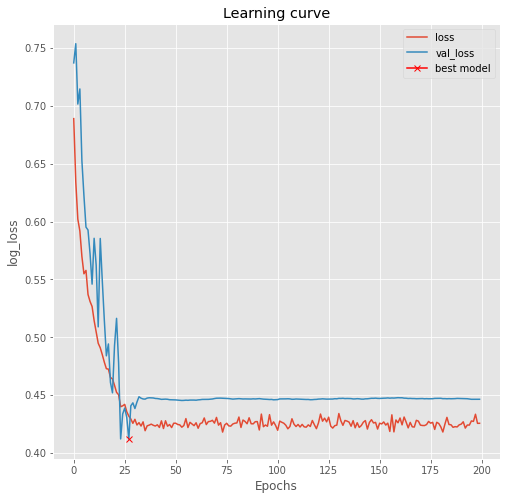

In [32]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

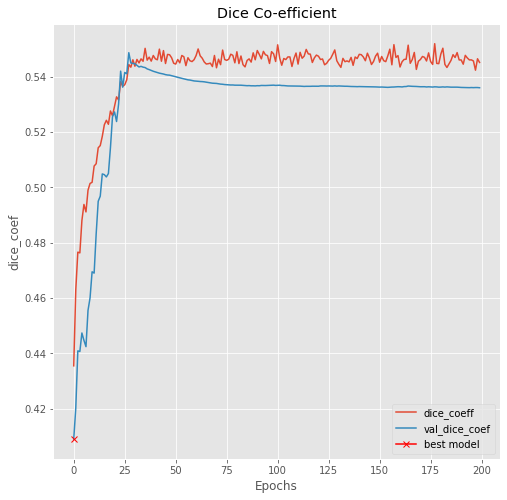

In [33]:
plt.figure(figsize=(8, 8))
plt.title("Dice Co-efficient")
plt.plot(results.history['dice_coef'], label="dice_coeff")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmin(results.history["val_dice_coef"]), np.min(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("dice_coef")
plt.legend();

In [0]:
# load the best model
model.load_weights('model-monuseg-SegNet.h5')

In [35]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_test, y_test, verbose=1)

14/14 [==============================] - 1s 91ms/step


[0.412004679441452, 0.6985825300216675, 0.5486539006233215]

In [36]:
# Predict on train, val and test
preds_test = model.predict(X_test, verbose=1)

14/14 [==============================] - 1s 78ms/step


In [0]:
# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('original')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Masks')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary');

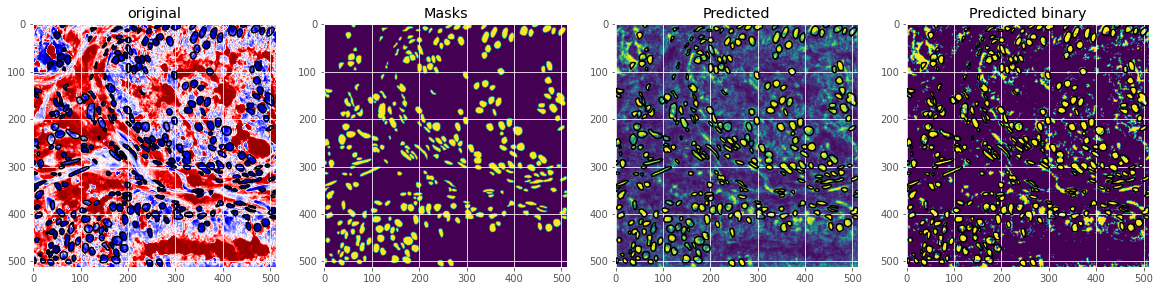

In [42]:
#prediction on test set
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=9)

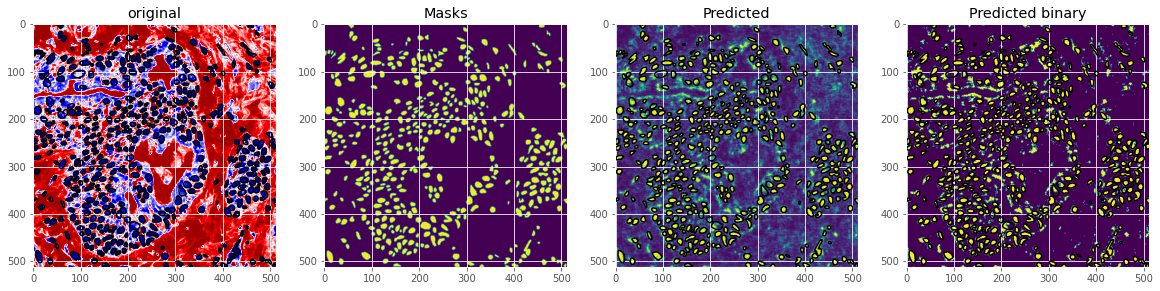

In [43]:
#prediction on test set
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=6)